# Importing and mapping reanalysis data with xarray and cartopy

### Mapping data from the 1993 "Storm of the Century" 

### Christopher McCray - [www.meteo.mcgill.ca/~cmccray](http://www.meteo.mcgill.ca/~cmccray/python)

In this tutorial, we'll be using [xarray](http://xarray.pydata.org/en/stable/) to import NetCDF data, [matplotlib](http://matplotlib.org/) to plot it, and [cartopy](http://scitools.org.uk/cartopy/) to map it. I'll go over the basic usage of each package, with a few more functions from elsewhere thrown in at times.

First, we import the necessary packages (below). The `plt.rcParams['figure.figsize']` just sets the size of the inline figures in this notebook to make them larger and easier to read.

In [14]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 12)

Let's load our data file. In this case, we have a NetCDF of Climate Forecast System Reanalysis [(CFSR)](http://cfs.ncep.noaa.gov/cfsr/) pressure level data from 12 UTC 14 March 1993 on a 0.5° x 0.5° lat-lon grid (downloaded/subset from [NCDC](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/climate-forecast-system-version2-cfsv2#CFS Reanalysis (CFSR)). Xarray provides a convenient interface for importing and analyzing NetCDF files. 

Run the cell below to load the data and print out some basic metadata!

In [15]:
dataFile = 'pgbh00.gdas.1993031412.nc'
#Open the dataset and print out metadeta
ds = xr.open_dataset(dataFile)
print ds

<xarray.Dataset>
Dimensions:                  (lat: 201, lon: 720, pressure: 37, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1993-03-14T12:00:00
  * lat                      (lat) float64 90.0 89.5 89.0 88.5 88.0 87.5 ...
  * lon                      (lon) float64 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 ...
  * pressure                 (pressure) float64 1e+05 9.75e+04 9.5e+04 ...
Data variables:
    Pressure_reduced_to_MSL  (time, lat, lon) float32 101394.0 101394.0 ...
    Absolute_vorticity       (time, pressure, lat, lon) float32 0.0001215 ...
    Geopotential_height      (time, pressure, lat, lon) float32 97.2256 ...
    Temperature              (time, pressure, lat, lon) float32 239.3 239.3 ...
    U-component_of_wind      (time, pressure, lat, lon) float32 3.19 3.14 ...
    V-component_of_wind      (time, pressure, lat, lon) float32 -6.26 -6.29 ...
Attributes:
    Conventions: CF-1.0
    Originating_center: US National Weather Service (NCEP) subcenter = 0
  

We can see that the dataset has 4 coordinates (time, lat, lon, and pressure) and 6 variables. We notice that the pressure coordinate is in Pascals. We can very easily convert these to hPa by dividing by 100, which will apply to all of the involved data.

In [16]:
ds['pressure'] = ds['pressure']/100

Let's first plot 500-hPa heights and absolute vorticity. We pull out some necessary fields, including our lat/lon coordinates for mapping. To index on coordinate values in xarray, use the `.sel` command. To index based on position (starting with 0), use `isel`. Since we only have one time value in this case, we select `time=0`.

In [17]:
lat = ds['lat']
lon = ds['lon']
hght = ds['Geopotential_height'].sel(pressure=500).isel(time=0)
avor = ds['Absolute_vorticity'].sel(pressure=500).isel(time=0)

### Mapping with cartopy

Cartopy makes mapping fairly intuitive and easy! First, we define our coordinate reference system (`ccrs`) and choose a projection from [those available](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html). We then create a figure and pass the chosen projection information to it (in this case, a Lambert Conformal conic projection) to create what's known as a GeoAxes instance. This is where we'll map all of our data. We can use [`set_extent`](http://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html?highlight=set_extent#cartopy.mpl.geoaxes.GeoAxes.set_extent) to zoom in on a certain lat/lon box. 

We can then quickly add various [features](http://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html) to the map, including a land background, lakes, country/state/provincial borders, etc. 

Here, I've set this all up as a function `plotMap()` which, when run, will create and return a figure with a background map on which to plot without the need to copy/paste all of this code each time.

Note that I've added a `zorder` argument to some features. `zorder` tells matplotlib where to draw the feature relative to the other parts of the plot, with 0 being the bottommost layer and increasing values being closer to the top layer of the figure. 

In [18]:
def plotMap():
    #Set the projection information
    proj = ccrs.LambertConformal(central_longitude=-97.0,central_latitude=53, standard_parallels=[53])
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([-45, -155, 10, 90])
    
    #Add map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS, zorder=10)
    ax.add_feature(cfeature.COASTLINE, zorder=10)

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
    
    #Add lat/lon gridlines every 20° to the map
    ax.gridlines(xlocs=np.arange(0,361,20), ylocs=np.arange(-80,90,20)) 
    
    return fig, ax

Now, let's plot our data! We first call `plotMap()` to get our background map and figure. Then, we specify the interval for our height contours. We use numpy's function `arange` to select a range of contours from 4320 to 6000 m, every 60 m (6 dam, the standard for 500-hPa. Note that the height field can easily be converted from meters to decameters in the way we converted the pressure coordinate above). Running `hght.min()` and `hght.max()` will show us that min and max values for 500-hPa heights in the dataset fall well within the range we've chosen to plot.

A key thing to note is the `transform` argument at the end of the `contour` call. This is what tells matplotlib to transform our variable in lat/lon coordinates onto our map projection coordinates.

We then plot absolute vorticity in filled contours. Matplotlib has many [colormaps](http://matplotlib.org/examples/color/colormaps_reference.html) from which to choose. Here, we use YlOrRd (yellow-orange-red). 

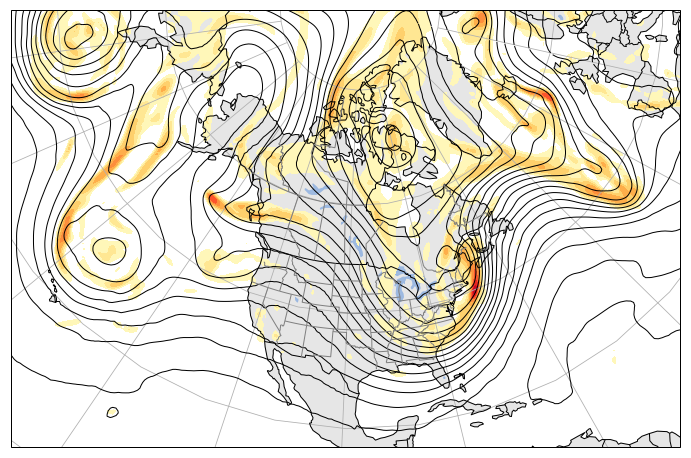

In [19]:
#Get a new background map figure
fig, ax = plotMap()

#Plot the 500-hPa height contours on the map, in black, with line width 1, and plot it above everything else.
hght_levels = np.arange(4320,6000,60)
ax.contour(lon, lat,hght, colors='k', levels=hght_levels, linewidths=1, zorder=3, transform = ccrs.PlateCarree())

#Now plot absolute vorticity as filled contours underneath height field, only values above 1.5e-4 s-1, 
# and use the YlOrRd colormap.
avor_levels = np.linspace(15e-5,60e-5, 10)
avor_contour = ax.contourf(lon, lat, avor, levels = avor_levels,  
                           cmap=plt.cm.YlOrRd, zorder=2, transform = ccrs.PlateCarree())

#Show the figure
fig

Great! Since fields can be somewhat noisy (particularly vorticity), we can smooth out the map a bit by using a Gaussian filter on the data (like the GWFS function in GEMPAK). To do this, we can use SciPy's [Guassian filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) function.

Additionally, we can add labels to our contours with `clabel`. We can format the labels as integers (`fmt='%1i'`) so that decimals don't appear.

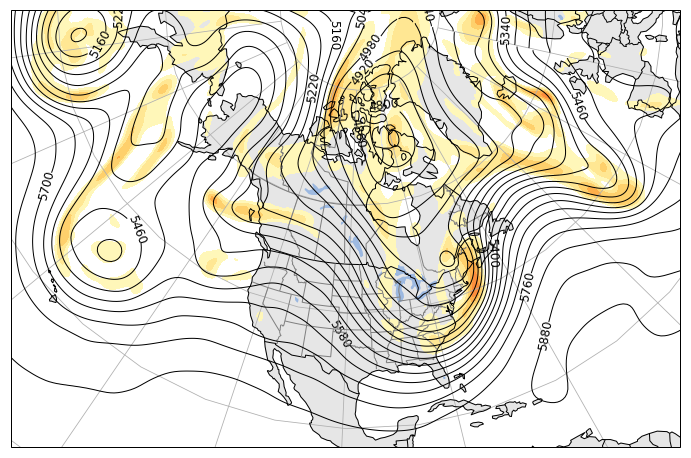

In [20]:
#Import scipy.ndimage to get the gaussian_filter function
import scipy.ndimage as ndimage

#Plot a new figure and map axes
fig, ax = plotMap()

#Smooth and re-plot the vorticity field
avor_smooth = ndimage.gaussian_filter(avor, sigma=1.5, order=0)
avor_contour = ax.contourf(lon, lat, avor_smooth, levels = avor_levels, zorder=2,  
                           cmap=plt.cm.YlOrRd, transform = ccrs.PlateCarree())

#Smooth and re-plot the height field
hght_smooth = ndimage.gaussian_filter(hght, sigma=3, order=0)
hght_contour = ax.contour(lon, lat, hght_smooth, levels=hght_levels, linewidths=1, colors='k',  
                          zorder=11,transform = ccrs.PlateCarree())

#Plot contour labels for the heights, leaving a break in the contours for the text (inline=True)
plt.clabel(hght_contour,  hght_levels, inline=True, fmt='%1i', fontsize=12)

fig

Let's add a colorbar for `avor`. Since the actual values have many leading zeros, we want to make the colorbar tick labels a bit more visually appealing. There are many ways to do this. One quick way is to simply multiply the tick label values, which are really our `avor_levels` values from above, by $10^5$

Let's also set a title. To get mathematical notations, we can use LaTeX-esque syntax between two $. Use the newline character \n to add a second line.

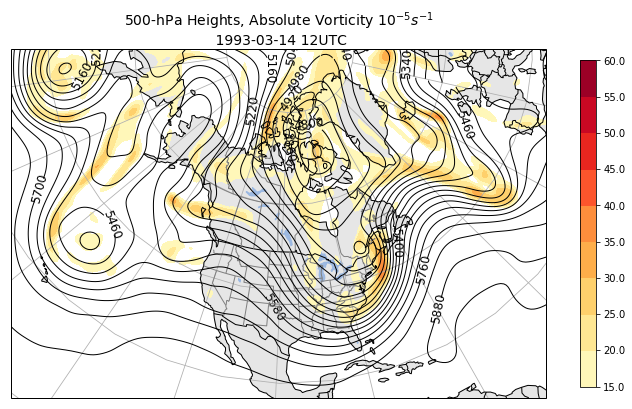

In [21]:
#Create a colorbar and shrink it down a bit.
cb = plt.colorbar(avor_contour, shrink=0.5)
#Change the tick labels
cb.set_ticklabels(avor_levels*10**5)

#Set the title
ax.set_title('500-hPa Heights, Absolute Vorticity $10^{-5} s^{-1}$\n 1993-03-14 12UTC', fontsize=14)

fig

Finally, cartopy also makes it fairly simple to plot wind barbs on our maps. We pull out our u and v wind components and plot them using `ax.barbs`. This time, we need to include a `.values` when retrieving our variables from the dataset, which outputs a simple array of data. If we don't do this, the extra metadeta causes problems for the `barbs` function, since it needs to run calculations on the components to get the wind direction and magnitude.

The other key here is `regrid_shape`, which takes the barbs and spaces them out in a natural way on our projection. Increasing `regrid_shape` increases the number/density of barbs. There are lots of other ways to customize the barbs, and you can also do [vectors/arrows](http://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.quiver) or [streamlines](http://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.streamplot)!

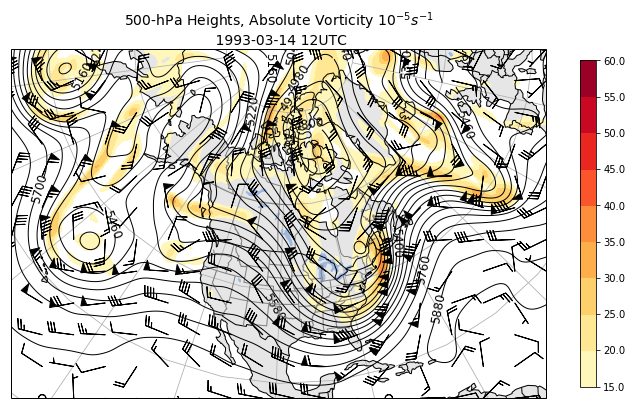

In [22]:
#Get the wind components
urel = ds['U-component_of_wind'].sel(pressure=500).isel(time=0).values*1.944
vrel = ds['V-component_of_wind'].sel(pressure=500).isel(time=0).values*1.944

#Plot the barbs
ax.barbs(lon, lat, urel, vrel, regrid_shape=12, zorder=20, transform=ccrs.PlateCarree())
fig

Finally, we update the title to mention the barbs

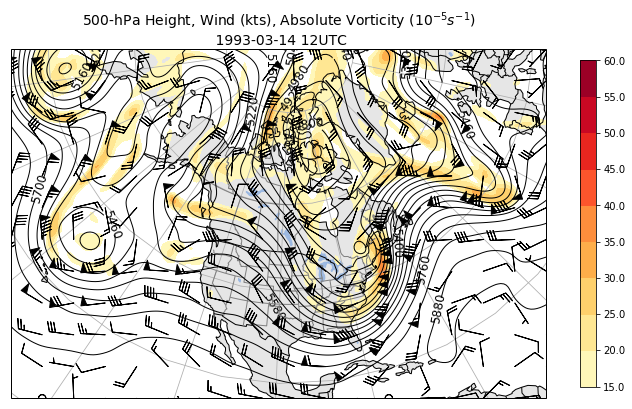

In [23]:
ax.set_title('500-hPa Height, Wind (kts), Absolute Vorticity ($10^{-5} s^{-1}$)\n 1993-03-14 12UTC', fontsize=14)

fig

We can save the figure using the `savefig` function below. To cut out any extra whitespace before saving, include the `bbox_inches='tight'`

In [24]:
plt.savefig('500_heights_winds_vort_930313_00.png', bbox_inches='tight')

That's all for now! If you have any questions or comments, feel free to contact me!